# Proyecto Final

Integrantes:
- Kroko
- Alan
- Nandy

### Enunciado

En este proyecto tendrá que trabajar con datos reales del departamento de la policía de la ciudad de nueva york y se enmarca en el contexto de seguridad y criminalidad en los barrios de la ciudad. **El objetivo de este proyecto es predecir la cantidad de delitos cada cierto tipo por barrio.**





El conjunto de datos a utilizar proviene de la página de datos abiertos de la ciudad de NY. (https://opendata.cityofnewyork.us) y comprenden datos desde el 2013 hasta el 2020 de arrestos, colisiones vehiculares y denuncias ciudadanas.

El dataset contiene diversos registros de distintos tipos de crimenes, en este estudio debe centrarse en los siguientes:
1. Delitos (Felonies)
2. Faltas (Misdemeanors)
3. Violaciones (Violations)

Esta categorización puede ser encontrada en la variable "LAW_CAT_CD"

Los barrios de estudio son:
- Staten Island
- Brooklyn
- Queens
- Manhattan
- Bronx

### Requerimientos



1. Seleccione al menos dos barrios de la ciudad y obtenga estimaciones de la cantidad de delitos, por tipo, ocurridos en la ciudad de NY semana a semana usando como conjunto de entrenamiento toda la data hasta el 2019 y como conjunto de pruebas el año 2020 completo. Compare distintas aproximaciones de modelamiento utilizando las métricas y modelos vistos en clases aunque se permite tambien usar métricas/modelos no discutidos (siempre y cuando se utilicen de manera correcta).
2. Deberá almacenar la informacion en una base de datos Postgres con el esquema de datos que usted prefiera
3. Utilizando Apache Airflow, cree un DAG que contenga al menos las siguientes tasks:
    - Data Processing: Extraerá la informacion de la based de datos Postgres
    - Data Processing: Procesará la informacióin extraida en la etapa anterior realizando todas las tareas de ingeniería de atributos que usted estime conveniente para sus modelos
    - Model Training: Utilizando la información generada en el punto anterior esta tasa debe ajustar los modelos a la data histórica con los hiperparámetros y configuración que usted haya estimado conveniente de su experimentación previa, una vez finalizado el entrenamiento debe almacenar el modelo donde usted estime conveniente. Este paso se debe realizar solo si no existe un modelo previamente entrenado, en cuyo caso se debe omitir este paso y pasar directamente al siguiente.
    - Model Inference: Utilizando un modelo ya entrenado, realice inferencias sobre el conjunto de pruebas y estas sean guardadas en una tabla de postgres.

4. Genere un informe breve donde se explique la metodología que utilizó para realizar los modelos justificando las decisiones tomadas a partir de lo observado en la experimientación. Explique tambien la infraestructura y el DAG generado.

### Consideraciones:


- Se recomienda realizar la experimentación sobre los datos en Jupyter para determinar la mejor configuración de los modelos de series de tiempo, una vez que haya obtenido un modelo con resultados satisfactorios incluya esta configuración en la tasa de Model Training.
- Sus modelos deben hacer predicciones a nivel semana, es decir, debe ser capaz de entregar para cada semana del 2020 disponible en los datos la cantidad de delitos de cada tipo que ocurrirán por barrio.
- Note que no se especificó la forma en que se debe pasar la informacion de una task a la siguiente, esto queda a criterio del equipo ya que hay muchas formas de hacerlo. Estudie e investigue cual es la que más le conviene para su caso o considear que es correcta. Lo mismo para el modelo en si.
- El entregable subido a aula debe contener al menos el notebook con los experimentos realizados, al menos un archivo .py con la definicion del DAG/tasks, el informe en formato PDF, un dump de la base de datos en formato .sql con las tablas que haya utilizado ya pobladas junto con un archivo en formato .txt o .json con la información necesaria para conectarse a la base de datos, y en caso de ser necesario, el modelo entrenado.
- Puesto que le pide usar una base de datos para almacenar la informacion durante las tasks necesitará hacer una conexión desde Python a Postgres: Queda prohibido incluir información sensible sobre la conexión al motor en los archivos .py, se le sugiere crear un archivo de configuracion en formato .json  (o el que guste) y que este sea leido simplemente desde el codigo, demas esta decir que si usa alguna herramienta de versionamiento de codigo ese archivo no deberia ser subido aunque para los efectos de la tarea subalo junto con el resto de los entregables. 
- Entregar codigo con informacion sensible sobre las conexiones al motor incurrirá en descuentos de puntaje
- Algo que le sera util es usar Docker.
- Este proyecto puede ser realizado en grupos de máximo tres personas.

## Pregunta 1: 

Selección de barrios y exploración de datos

In [1]:
import pandas as pd
import sklearn
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

Seleccionamos del dataset aquellos registros de 2019 y 2020 para su posterior uso

In [2]:
# ya que debemos ocupar el 2019 como entrenamiento, y el 2020 como prueba, vamos a sacar slices de la data.

# df = pd.read_csv("./Data/NYPD_Arrests_Data__Historic_.csv")
# df.head()

In [3]:
# df["ARREST_DATE"] = pd.to_datetime(df["ARREST_DATE"])
# df_2019 = df[df["ARREST_DATE"].dt.year == 2019]
# df_2020 = df[df["ARREST_DATE"].dt.year == 2020]
# df_2019.info()

In [4]:
## Lo guardamos en un CSV para su manipulación:

# df_2019.to_csv("./Data/NYPD_ARRESTS_DATA_2019.csv", index=False)
# df_2020.to_csv("./Data/NYPD_ARRESTS_DATA_2020.csv", index=False)

### EDA:

In [16]:
## Revisamos los datasets para Train y Test

df_2019 = pd.read_csv("./Data/NYPD_ARRESTS_DATA_2019.csv")
df_2020 = pd.read_csv("./Data/NYPD_ARRESTS_DATA_2020.csv")

print("Train data: ", df_2019.shape)
print("Test data: ",df_2020.shape)

Train data:  (213248, 19)
Test data:  (139024, 19)


Data Cleaning:

In [17]:
print("Train missing values:")
print(df_2019.isnull().sum())
print()
print("Test missing values:")
print(df_2020.isnull().sum())
print()
print("Train duplicated: ", df_2019.duplicated().sum())
print("Test duplicated: ", df_2020.duplicated().sum())

Train missing values:
ARREST_KEY             0
ARREST_DATE            0
PD_CD                 41
PD_DESC              159
KY_CD                159
OFNS_DESC            159
LAW_CODE               0
LAW_CAT_CD             0
ARREST_BORO            0
ARREST_PRECINCT        0
JURISDICTION_CODE      0
AGE_GROUP              0
PERP_SEX               0
PERP_RACE              0
X_COORD_CD             0
Y_COORD_CD             0
Latitude               0
Longitude              0
Lon_Lat                0
dtype: int64

Test missing values:
ARREST_KEY            0
ARREST_DATE           0
PD_CD                23
PD_DESC              37
KY_CD                37
OFNS_DESC            37
LAW_CODE              0
LAW_CAT_CD            0
ARREST_BORO           0
ARREST_PRECINCT       0
JURISDICTION_CODE     0
AGE_GROUP             0
PERP_SEX              0
PERP_RACE             0
X_COORD_CD            0
Y_COORD_CD            0
Latitude              0
Longitude             0
Lon_Lat               0
dtype: int64

In [18]:
df_2019.dropna(subset=["LAW_CAT_CD"], inplace=True)
df_2020.dropna(subset=["LAW_CAT_CD"], inplace=True)

In [19]:
df_2019.dtypes

ARREST_KEY             int64
ARREST_DATE           object
PD_CD                float64
PD_DESC               object
KY_CD                float64
OFNS_DESC             object
LAW_CODE              object
LAW_CAT_CD            object
ARREST_BORO           object
ARREST_PRECINCT        int64
JURISDICTION_CODE    float64
AGE_GROUP             object
PERP_SEX              object
PERP_RACE             object
X_COORD_CD           float64
Y_COORD_CD           float64
Latitude             float64
Longitude            float64
Lon_Lat               object
dtype: object

In [20]:
# Convertiremos estos datos en algo legible a continuacion:

df_2019["LAW_CAT_CD"] = df_2019["LAW_CAT_CD"].replace({"F": "Felony", "M": "Misdemeanor", "V": "Violation"})
df_2020["LAW_CAT_CD"] = df_2020["LAW_CAT_CD"].replace({"F": "Felony", "M": "Misdemeanor", "V": "Violation"})
df_2019["ARREST_BORO"] = df_2019["ARREST_BORO"].replace({"B": "Bronx", "K": "Brooklyn", "M": "Manhattan", "Q": "Queens", "S": "Staten Island"})
df_2020["ARREST_BORO"] = df_2020["ARREST_BORO"].replace({"B": "Bronx", "K": "Brooklyn", "M": "Manhattan", "Q": "Queens", "S": "Staten Island"})

df_2019.head()


,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,192799737,2019-01-26,177.0,SEXUAL ABUSE,116.0,SEX CRIMES,PL 1306503,Felony,Manhattan,25,0.0,45-64,M,BLACK,1000555.0,230994.0,40.800694,-73.941109,POINT (-73.94110928599997 40.800694331000045)
1,193260691,2019-02-06,NaN,NaN,NaN,NaN,PL 2203400,Felony,Manhattan,14,0.0,25-44,M,UNKNOWN,986685.0,215375.0,40.757839,-73.991212,POINT (-73.99121211099998 40.75783900300007)
2,196324211,2019-04-23,157.0,RAPE 1,104.0,RAPE,PL 1303501,Felony,Brooklyn,77,0.0,45-64,M,BLACK HISPANIC,1003606.0,185050.0,40.674583,-73.930222,POINT (-73.93022154099998 40.67458330800008)
3,196785901,2019-05-04,175.0,"SEXUAL ABUSE 3,2",233.0,SEX CRIMES,PL 13052A1,Misdemeanor,Bronx,50,0.0,25-44,M,BLACK,1011257.0,261130.0,40.883383,-73.902333,POINT (-73.90233330899997 40.88338257900006)
4,197554056,2019-05-23,175.0,"SEXUAL ABUSE 3,2",233.0,SEX CRIMES,PL 13052A1,Misdemeanor,Manhattan,26,0.0,45-64,F,BLACK,996241.0,236149.0,40.814850,-73.956682,POINT (-73.95668184799996 40.81485028900005)


Ahora si, la 1


In [21]:
train_data = df_2019.copy()
test_data = df_2020.copy()

# Convertimos la fecha en un formato legible para el modelo:
train_data['ARREST_DATE'] = pd.to_datetime(train_data['ARREST_DATE'])
test_data['ARREST_DATE'] = pd.to_datetime(test_data['ARREST_DATE'])

In [22]:


# Count arrests per week for train_data
train_arrest_count = train_data.groupby([pd.Grouper(key='ARREST_DATE', freq='W'), 'LAW_CAT_CD', 'ARREST_BORO']).size().reset_index(name='ARREST_COUNT')

# Count arrests per week for test_data
test_arrest_count = test_data.groupby([pd.Grouper(key='ARREST_DATE', freq='W'), 'LAW_CAT_CD', 'ARREST_BORO']).size().reset_index(name='ARREST_COUNT')

print(train_arrest_count.isnull().sum())

train_arrest_count.head()

ARREST_DATE     0
LAW_CAT_CD      0
ARREST_BORO     0
ARREST_COUNT    0
dtype: int64


,ARREST_DATE,LAW_CAT_CD,ARREST_BORO,ARREST_COUNT
0,2019-01-06,Felony,Bronx,275
1,2019-01-06,Felony,Brooklyn,473
2,2019-01-06,Felony,Manhattan,310
3,2019-01-06,Felony,Queens,282
4,2019-01-06,Felony,Staten Island,59


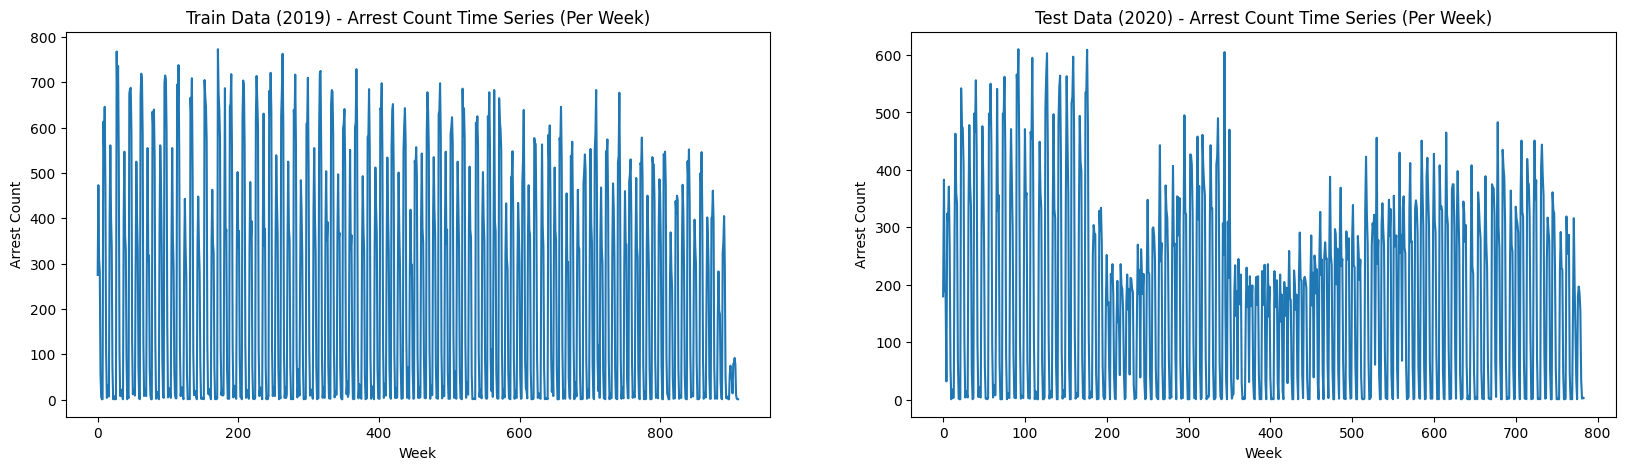

In [23]:
# Plot the time series for train_data
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(train_arrest_count.index, train_arrest_count['ARREST_COUNT'])
axs[0].set_xlabel('Week')
axs[0].set_ylabel('Arrest Count')
axs[0].set_title('Train Data (2019) - Arrest Count Time Series (Per Week)')

# Plot the time series for test_data
axs[1].plot(test_arrest_count.index, test_arrest_count['ARREST_COUNT'])
axs[1].set_xlabel('Week')
axs[1].set_ylabel('Arrest Count')
axs[1].set_title('Test Data (2020) - Arrest Count Time Series (Per Week)')
plt.show()

C:\Users\n3mes\AppData\Local\Temp\ipykernel_29752\1573164589.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = plt.cm.get_cmap('tab10')


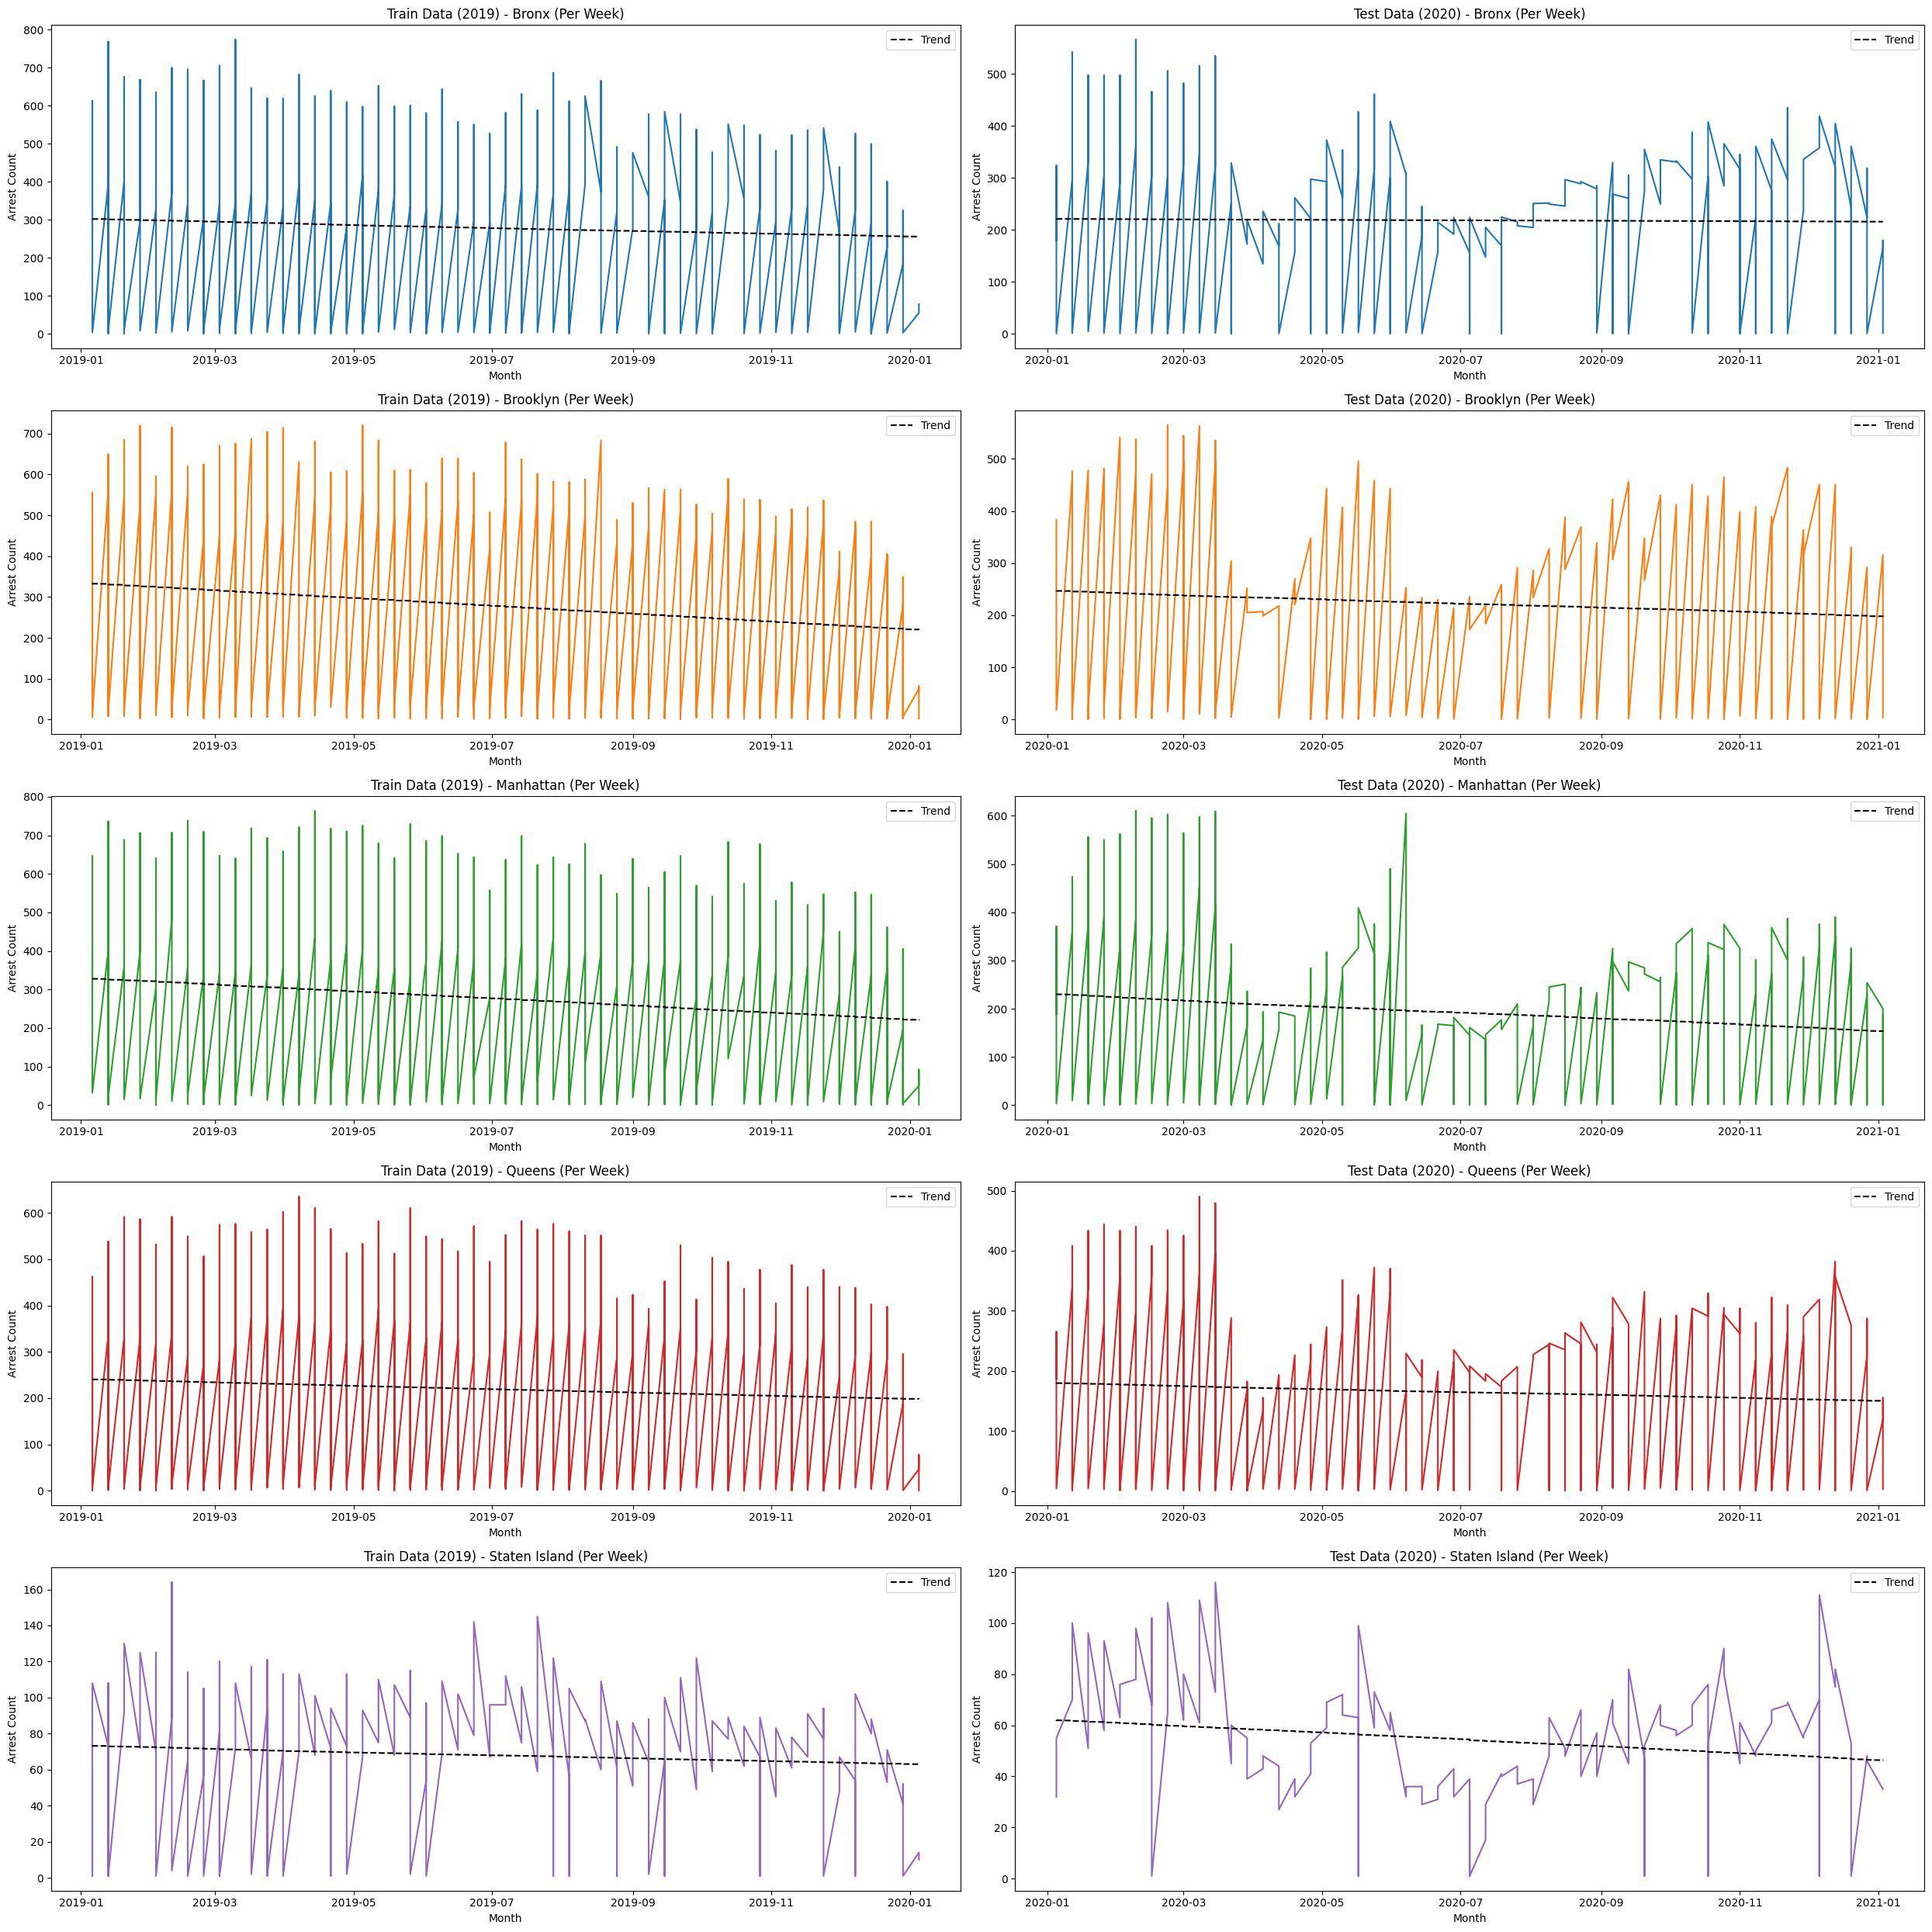

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Get unique boroughs from the train_data and test_data
boroughs_train = train_arrest_count['ARREST_BORO'].unique()
boroughs_test = test_arrest_count['ARREST_BORO'].unique()

# Define a color palette for the boroughs
color_palette = plt.cm.get_cmap('tab10')

# Create subplots with two columns for train_data and test_data
fig, axs = plt.subplots(len(boroughs_train), 2, figsize=(25, 5*len(boroughs_train)))

# Iterate over boroughs_train and plot the time series for each borough in the train_data column
for i, borough in enumerate(boroughs_train):
    train_data_borough = train_arrest_count[train_arrest_count['ARREST_BORO'] == borough]
    color = color_palette(i % 10)
    axs[i, 0].plot(train_data_borough['ARREST_DATE'], train_data_borough['ARREST_COUNT'], color=color)
    axs[i, 0].set_xlabel('Month')
    axs[i, 0].set_ylabel('Arrest Count')
    axs[i, 0].set_title(f'Train Data (2019) - {borough} (Per Week)')

    # Calculate the trend line using linear regression
    x = np.arange(len(train_data_borough))
    trend = np.polyfit(x, train_data_borough['ARREST_COUNT'], 1)
    trend_line = np.polyval(trend, x)
    
    axs[i, 0].plot(train_data_borough['ARREST_DATE'], trend_line, color='black', linestyle='--', label='Trend')

    axs[i, 0].legend()

# Iterate over boroughs_test and plot the time series for each borough in the test_data column
for i, borough in enumerate(boroughs_test):
    test_data_borough = test_arrest_count[test_arrest_count['ARREST_BORO'] == borough]
    color = color_palette(i % 10)
    axs[i, 1].plot(test_data_borough['ARREST_DATE'], test_data_borough['ARREST_COUNT'], color=color)
    axs[i, 1].set_xlabel('Month')
    axs[i, 1].set_ylabel('Arrest Count')
    axs[i, 1].set_title(f'Test Data (2020) - {borough} (Per Week)')

    # Calculate the trend line using linear regression
    x = np.arange(len(test_data_borough))
    trend = np.polyfit(x, test_data_borough['ARREST_COUNT'], 1)
    trend_line = np.polyval(trend, x)
    
    axs[i, 1].plot(test_data_borough['ARREST_DATE'], trend_line, color='black', linestyle='--', label='Trend')

    axs[i, 1].legend()

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()



In [25]:
# %pip install statsmodels
# %pip install prophet

In [26]:
train_arrest_pivot = train_arrest_count.pivot(index='ARREST_DATE', columns=['LAW_CAT_CD', 'ARREST_BORO'], values='ARREST_COUNT')
test_arrest_pivot = test_arrest_count.pivot(index='ARREST_DATE', columns=['LAW_CAT_CD', 'ARREST_BORO'], values='ARREST_COUNT')

print(train_arrest_pivot.isnull().sum())

train_arrest_pivot = train_arrest_pivot.fillna(0)


train_arrest_pivot.head()


LAW_CAT_CD   ARREST_BORO  
Felony       Bronx             0
             Brooklyn          0
             Manhattan         0
             Queens            0
             Staten Island     0
I            Brooklyn          2
             Queens           10
             Staten Island    42
Misdemeanor  Bronx             0
             Brooklyn          0
             Manhattan         0
             Queens            0
             Staten Island     0
Violation    Bronx             6
             Brooklyn          0
             Manhattan         0
             Queens            0
I            Bronx            32
             Manhattan        18
Violation    Staten Island    38
dtype: int64


LAW_CAT_CD  Felony                                                I         \
ARREST_BORO  Bronx Brooklyn Manhattan Queens Staten Island Brooklyn Queens   
ARREST_DATE                                                                  
2019-01-06   275.0    473.0     310.0  282.0          59.0      6.0    1.0   
2019-01-13   394.0    561.0     402.0  337.0          73.0      8.0    2.0   
2019-01-20   402.0    547.0     361.0  331.0          92.0      8.0    4.0   
2019-01-27   297.0    525.0     400.0  330.0          72.0      3.0    1.0   
2019-02-03   327.0    555.0     305.0  318.0          70.0     10.0    1.0   

LAW_CAT_CD                Misdemeanor                                          \
ARREST_BORO Staten Island       Bronx Brooklyn Manhattan Queens Staten Island   
ARREST_DATE                                                                     
2019-01-06            1.0       613.0    556.0     646.0  462.0         108.0   
2019-01-13            1.0       768.0    649.0     736.0  538.0         108.0   
2019-01-20            0.0       675.0    685.0     688.0  591.0         130.0   
2019-01-27            0.0       668.0    719.0     706.0  586.0         125.0   
2019-02-03            0.0       635.0    595.0     640.0  532.0         125.0   

LAW_CAT_CD  Violation                               I               Violation  
ARREST_BORO     Bronx Brooklyn Manhattan Queens Bronx Manhattan Staten Island  
ARREST_DATE                                                                    
2019-01-06        4.0     14.0      32.0    7.0   0.0       0.0           0.0  
2019-01-13        8.0     20.0      22.0    7.0   1.0       1.0           1.0  
2019-01-20       12.0     22.0      15.0    9.0   1.0       0.0           0.0  
2019-01-27        8.0     24.0      17.0    8.0   0.0       0.0           0.0  
2019-02-03        2.0     17.0      17.0    9.0   0.0       1.0           1.0

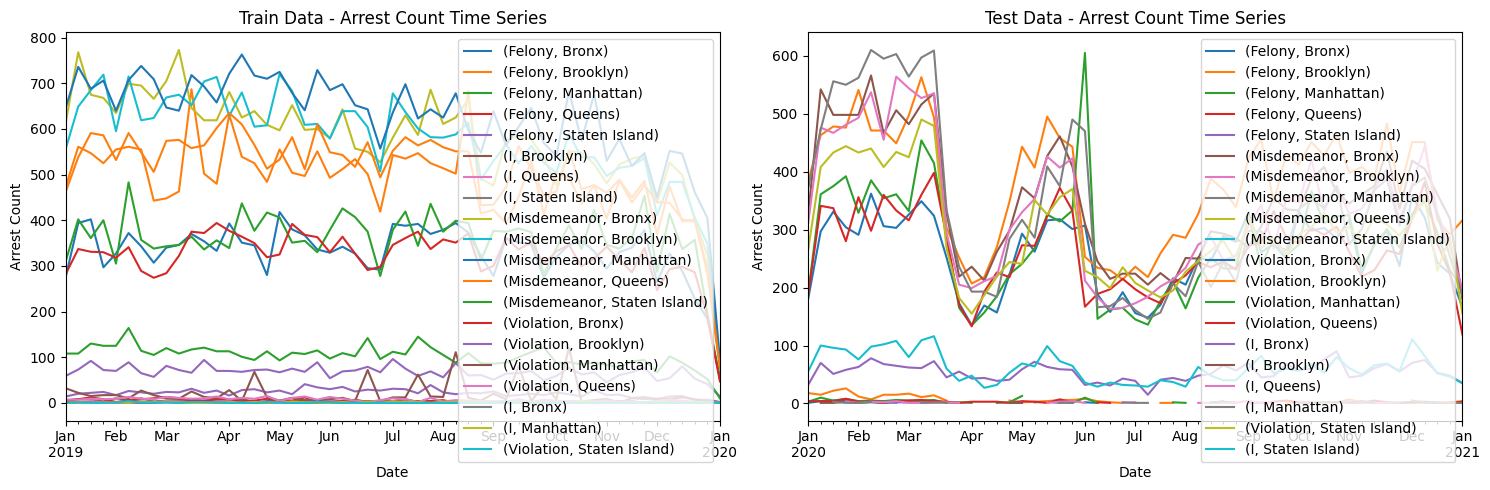

(53, 20)


In [27]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plotting the train data
train_arrest_pivot.plot(ax=axs[0])
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Arrest Count')
axs[0].set_title('Train Data - Arrest Count Time Series')
axs[0].legend(loc='upper right')

# Plotting the test data
test_arrest_pivot.plot(ax=axs[1])
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Arrest Count')
axs[1].set_title('Test Data - Arrest Count Time Series')
axs[1].legend(loc='upper right')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

print(train_arrest_pivot.shape)

### Buscando los modelos

#### Hyperparameter Tuning for ARIMA

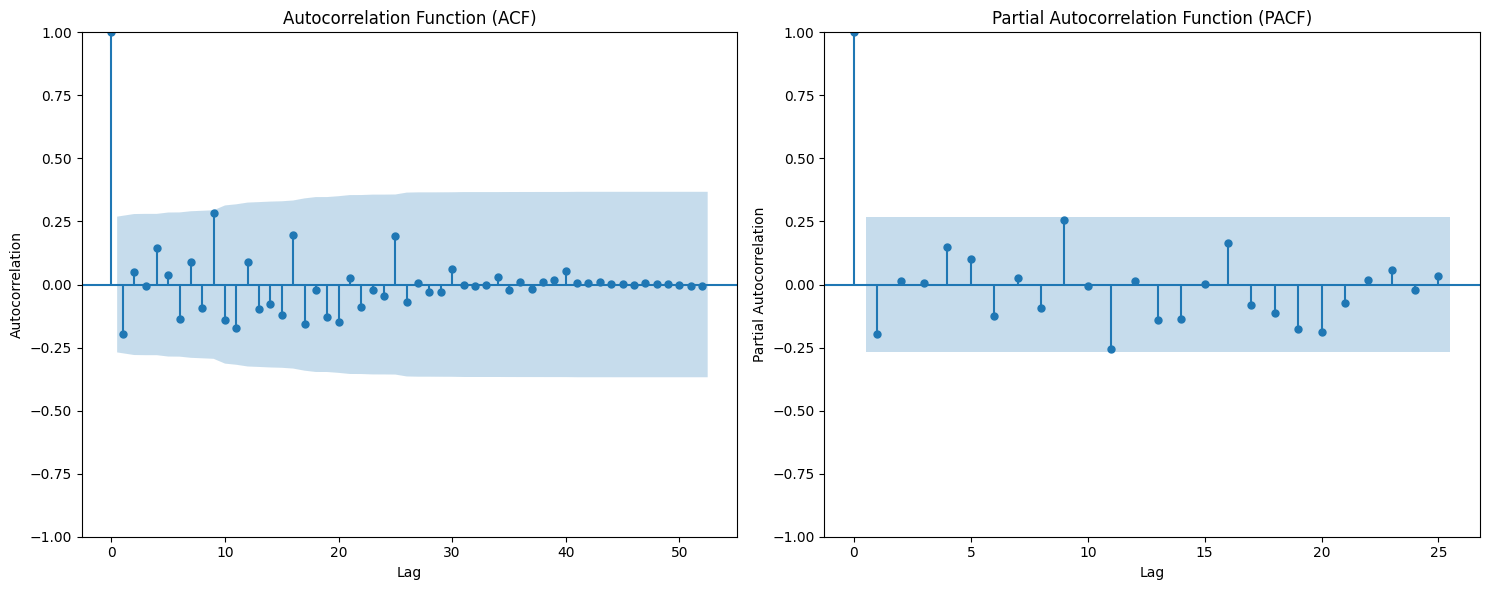

c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency informatio

Best AIC: 494.47826910783857
Best BIC: 498.3807565450014
Best Order: (0, 1, 1)


In [28]:
## ARIMA Hyperparameter Tuning

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Prepare the data in a pandas DataFrame
data_hyp = train_arrest_pivot.xs(('Violation', 'Manhattan'), level=('LAW_CAT_CD', 'ARREST_BORO'), axis=1)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot ACF
sm.graphics.tsa.plot_acf(data_hyp, lags=52, ax=axs[0])
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('Autocorrelation')
axs[0].set_title('Autocorrelation Function (ACF)')

# Plot PACF
sm.graphics.tsa.plot_pacf(data_hyp, lags=25, ax=axs[1])
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('Partial Autocorrelation')
axs[1].set_title('Partial Autocorrelation Function (PACF)')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

# Define a function to evaluate ARIMA models and return AIC and BIC
def evaluate_arima_model(order):
    model = sm.tsa.ARIMA(data_hyp, order=order, freq='W')
    model_fit = model.fit()
    aic = model_fit.aic
    bic = model_fit.bic
    return aic, bic

# Define ranges for p, d, and q
p_values = range(0, 4)  # Example range for p
d_values = range(0, 2)  # Example range for d
q_values = range(0, 4)  # Example range for q

best_aic = float('inf')
best_bic = float('inf')
best_order = None

# Iterate over all possible combinations of p, d, and q values
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                aic, bic = evaluate_arima_model(order)
                if aic < best_aic:
                    best_aic = aic
                    best_bic = bic
                    best_order = order
            except:
                continue

print("Best AIC:", best_aic)
print("Best BIC:", best_bic)
print("Best Order:", best_order)


In [42]:
# Define a list to store the predictions for each borough and law category
predictions = []

# Iterate over each law category
for law_cat_cd in train_arrest_pivot.columns.get_level_values('LAW_CAT_CD').unique():
    # Iterate over each borough
    for borough in train_arrest_pivot.columns.get_level_values('ARREST_BORO').unique():
        # Prepare the data for the specific law category and borough
        data = train_arrest_pivot.xs((law_cat_cd, borough), level=('LAW_CAT_CD', 'ARREST_BORO'), axis=1)
        
        # Fit the ARIMA model with the best order to the data
        model = sm.tsa.ARIMA(data, order=best_order, freq='W')
        model_fit = model.fit()
        
        # Make predictions for the desired time period
        predictions_borough = model_fit.predict(start=len(data), end=len(data) + len(test_arrest_count) - 1)
        
        # Append the predictions to the list
        predictions.append(predictions_borough)

# Combine the predictions for all boroughs and law categories
all_predictions = pd.concat(predictions, axis=1)

# Set the column names to the appropriate boroughs and law categories
all_predictions.columns = pd.MultiIndex.from_product([train_arrest_pivot.columns.get_level_values('LAW_CAT_CD').unique(),
                                                     train_arrest_pivot.columns.get_level_values('ARREST_BORO').unique()],
                                                    names=['LAW_CAT_CD', 'ARREST_BORO'])






c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:

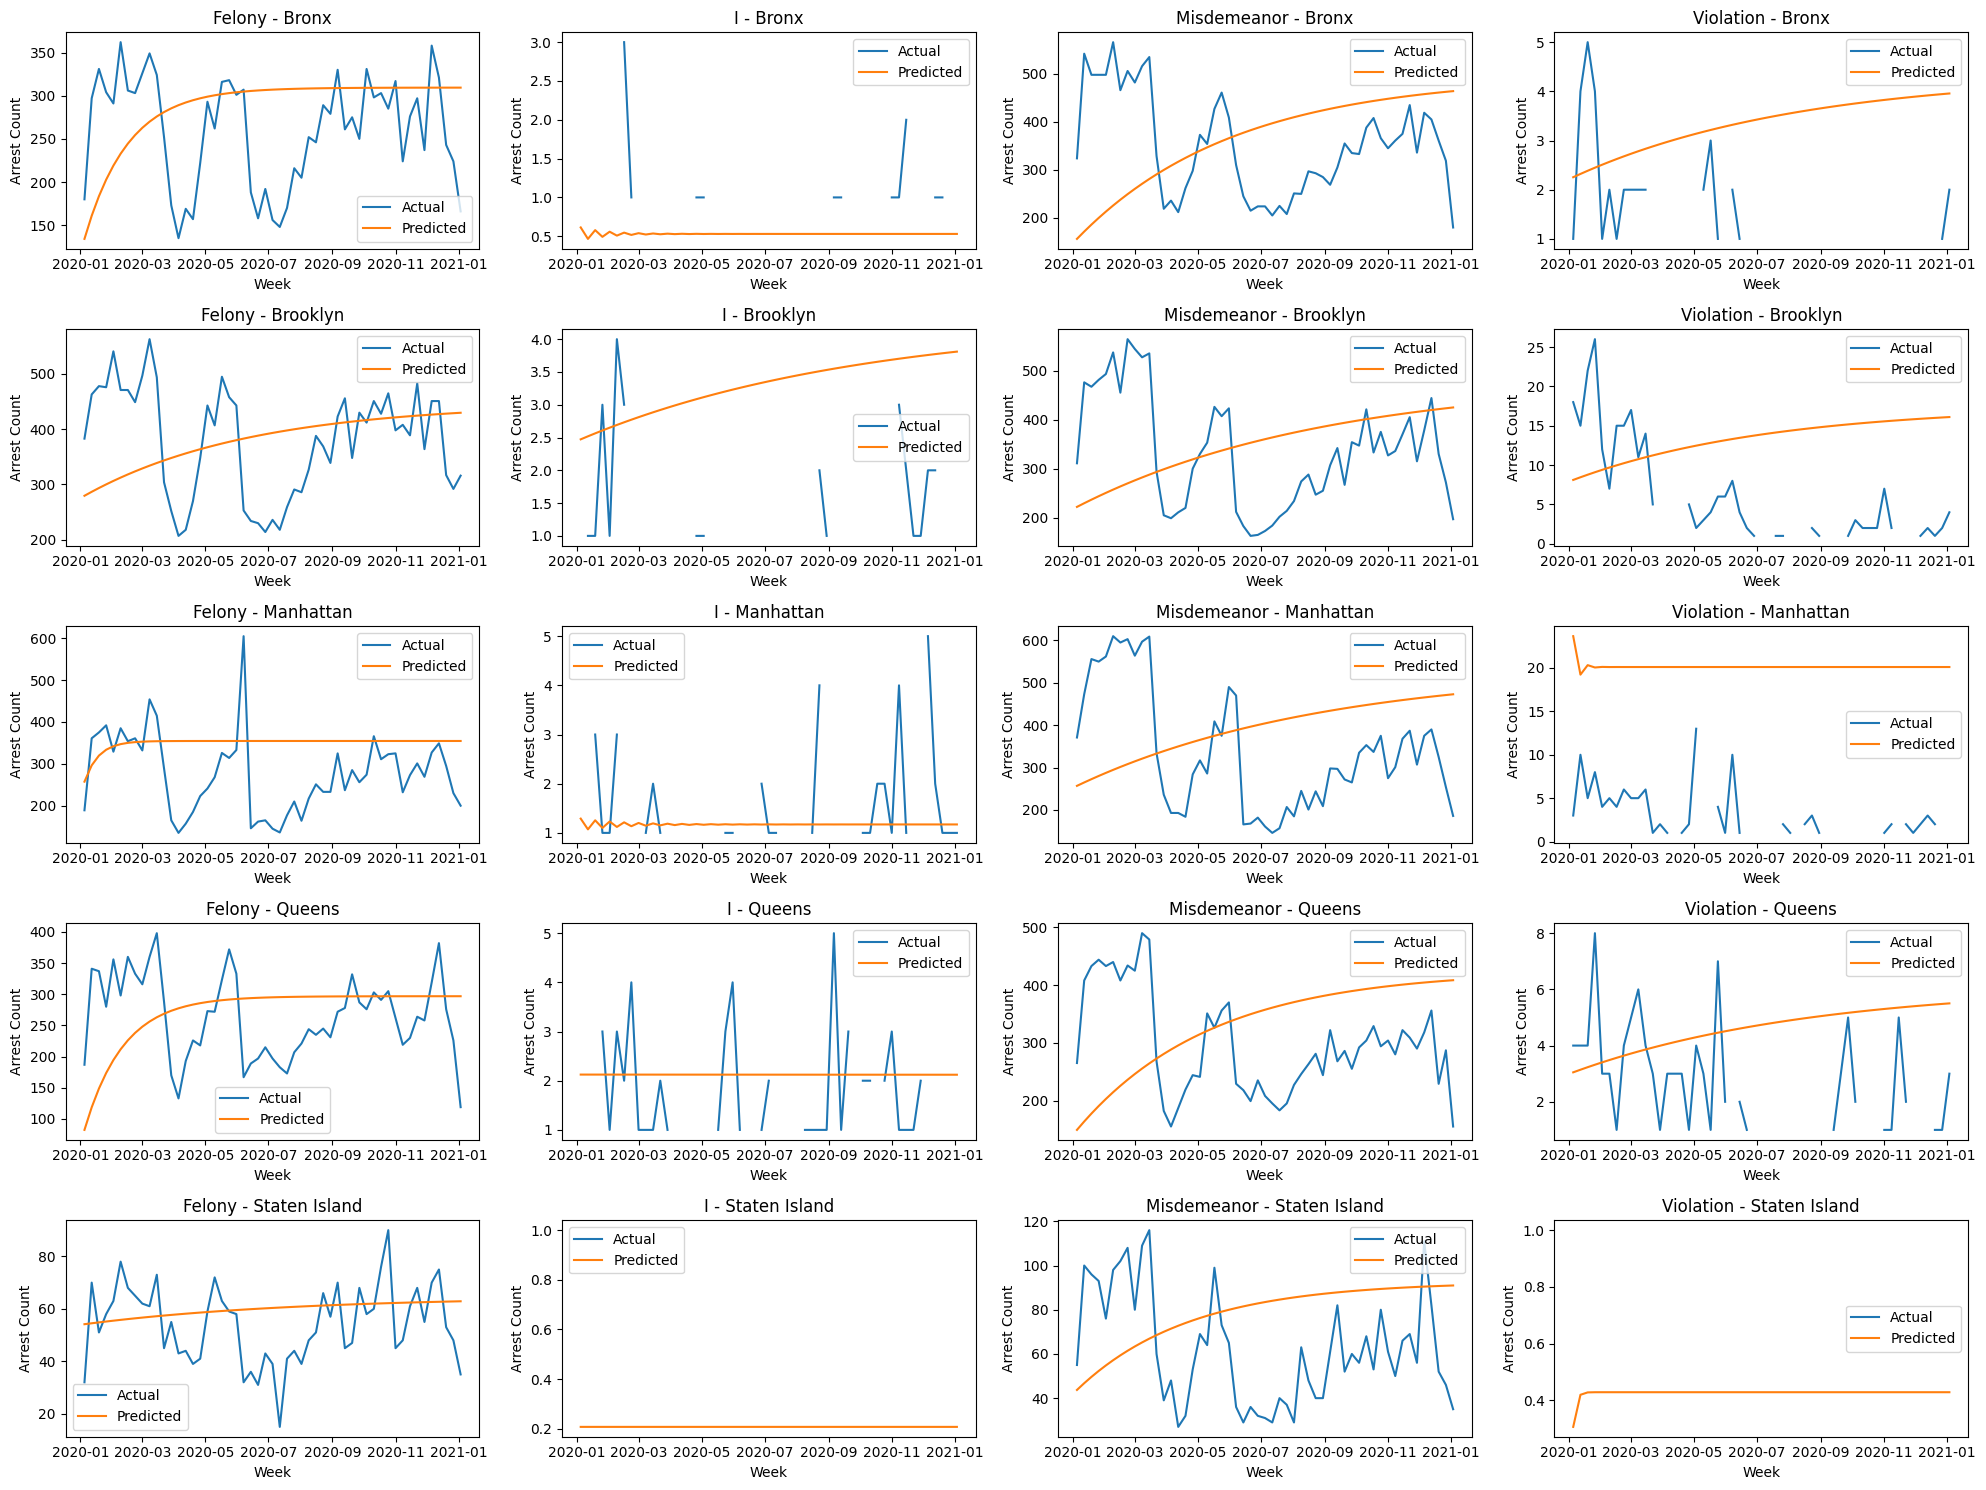

In [43]:
# Plot the predictions for each borough and law category
fig, axs = plt.subplots(len(train_arrest_pivot.columns.get_level_values('ARREST_BORO').unique()), len(train_arrest_pivot.columns.get_level_values('LAW_CAT_CD').unique()), figsize=(20, 15))

for i, borough in enumerate(train_arrest_pivot.columns.get_level_values('ARREST_BORO').unique()):
    for j, law_cat_cd in enumerate(train_arrest_pivot.columns.get_level_values('LAW_CAT_CD').unique()):
        try:
            borough_predictions = all_predictions[(law_cat_cd, borough)]
        except KeyError:
            # Handle missing predictions
            continue
        
        if (law_cat_cd, borough) in test_arrest_pivot.columns:
            test_data = test_arrest_pivot[(law_cat_cd, borough)]
            
            # Adjust the lengths of the arrays
            test_data = test_data.iloc[:len(borough_predictions)]
            borough_predictions = borough_predictions[:len(test_data)]
            
            axs[i, j].plot(test_data.index, test_data, label='Actual')
            axs[i, j].plot(test_data.index, borough_predictions, label='Predicted')
            axs[i, j].set_xlabel('Week')
            axs[i, j].set_ylabel('Arrest Count')
            axs[i, j].set_title(f'{law_cat_cd} - {borough}')
            axs[i, j].legend()
        else:
            print(f"No data available for {law_cat_cd} - {borough}")

plt.tight_layout()
plt.show()



### SARIMAX


In [30]:
# %pip install pmdarima

In [31]:
import pmdarima as pm

auto_train_array = train_arrest_pivot.values.flatten()

model = pm.auto_arima(
    auto_train_array, 
    seasonal=True, 
    m=52, 
    suppress_warnings=True,
    stepwise=True,
    error_action='ignore',
    trace=True,
    start_p=1,
    start_q=1,
    test='adf',
    max_p=5,
    max_q=5,)

print(model.summary())

best_order = model.order
best_seasonal_order = model.seasonal_order


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[52] intercept   : AIC=inf, Time=12.41 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=14648.060, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=14008.897, Time=6.01 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=13942.575, Time=6.14 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=15203.209, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[52] intercept   : AIC=14001.558, Time=0.18 sec
 ARIMA(0,0,1)(1,0,1)[52] intercept   : AIC=inf, Time=11.57 sec
 ARIMA(0,0,1)(0,0,2)[52] intercept   : AIC=inf, Time=83.57 sec
 ARIMA(0,0,1)(1,0,0)[52] intercept   : AIC=13985.123, Time=5.23 sec
 ARIMA(0,0,1)(1,0,2)[52] intercept   : AIC=inf, Time=149.04 sec
 ARIMA(0,0,0)(0,0,1)[52] intercept   : AIC=14593.125, Time=2.32 sec
 ARIMA(1,0,1)(0,0,1)[52] intercept   : AIC=13829.405, Time=10.15 sec
 ARIMA(1,0,1)(0,0,0)[52] intercept   : AIC=13932.819, Time=0.29 sec
 ARIMA(1,0,1)(0,0,2)[52] intercept   : AIC=inf, Time=116.03 sec
 ARIMA(1,0,1)(1,0,0)[52] in

c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predictions for Felony - Bronx:
2020-01-12    173.640930
2020-01-19    178.865370
2020-01-26     90.079893
2020-02-02    113.606837
2020-02-09    149.612811
2020-02-16    124.054716
2020-02-23     92.672860
2020-03-01    118.695055
2020-03-08    122.254588
2020-03-15    140.788979
2020-03-22    126.045422
2020-03-29    107.141987
2020-04-05    155.625936
2020-04-12    119.251347
2020-04-19    112.826619
2020-04-26     57.316982
2020-05-03    170.692003
2020-05-10    137.644558
2020-05-17    125.395574
2020-05-24     98.171418
2020-05-31     90.913775
2020-06-07    100.294864
2020-06-14     86.381328
2020-06-21     58.324560
2020-06-28     54.394024
2020-07-05    136.153643
2020-07-12    131.390819
2020-07-19    133.283379
2020-07-26    113.545196
2020-08-02    119.597130
2020-08-09    130.640555
2020-08-16    111.733783
2020-08-23     67.868484
2020-08-30     29.826617
2020-09-06     96.609627
2020-09-13     88.517409
2020-09-20     82.088896
2020-09-27     21.583776
2020-10-04     57.

c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Predictions for I - Bronx:
2020-01-12    0.999492
2020-01-19    0.999492
2020-01-26    0.000076
2020-02-02    0.000076
2020-02-09    0.000076
2020-02-16    0.000076
2020-02-23    0.999492
2020-03-01    1.998908
2020-03-08    0.999492
2020-03-15    1.998907
2020-03-22    0.000075
2020-03-29    1.998907
2020-04-05    0.999491
2020-04-12    0.999491
2020-04-19    0.999491
2020-04-26    0.999491
2020-05-03    0.999491
2020-05-10    0.000075
2020-05-17    0.000075
2020-05-24    0.000075
2020-05-31    0.999491
2020-06-07    0.000075
2020-06-14    0.000075
2020-06-21    0.000075
2020-06-28    1.998907
2020-07-05    0.000075
2020-07-12    2.998322
2020-07-19    0.000074
2020-07-26    0.000074
2020-08-02    0.999490
2020-08-09    0.000074
2020-08-16    0.000074
2020-08-23    0.000074
2020-08-30    0.000074
2020-09-06    0.999490
2020-09-13    0.999490
2020-09-20    0.000074
2020-09-27    0.000074
2020-10-04    0.999490
2020-10-11    0.000074
2020-10-18    0.000074
2020-10-25    0.000074
2020-11

c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predictions for Misdemeanor - Bronx:
2020-01-12    229.534194
2020-01-19    153.681965
2020-01-26    145.350459
2020-02-02    116.605565
2020-02-09    164.017778
2020-02-16    158.041310
2020-02-23    132.436577
2020-03-01    160.220295
2020-03-08    210.772550
2020-03-15    108.225121
2020-03-22     84.190171
2020-03-29     81.353504
2020-04-05    127.194528
2020-04-12     80.390564
2020-04-19     88.545298
2020-04-26     62.154365
2020-05-03     49.895577
2020-05-10     90.240106
2020-05-17     45.005777
2020-05-24     43.738377
2020-05-31     25.198078
2020-06-07     71.823109
2020-06-14      1.464239
2020-06-21     -6.869807
2020-06-28    -27.765999
2020-07-05     11.792378
2020-07-12     47.424994
2020-07-19     10.825886
2020-07-26     85.714535
2020-08-02     23.991127
2020-08-09     32.143797
2020-08-16     60.709607
2020-08-23    -78.741681
2020-08-30    -93.358076
2020-09-06    -16.899995
2020-09-13    -14.243895
2020-09-20    -22.579701
2020-09-27    -56.824804
2020-10-04   

c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predictions for Violation - Bronx:
2020-01-12    3.114830
2020-01-19    6.194675
2020-01-26    3.049143
2020-02-02   -1.652756
2020-02-09    0.648830
2020-02-16    2.950385
2020-02-23    4.473741
2020-03-01    6.775234
2020-03-08    4.407684
2020-03-15    0.483766
2020-03-22   -0.327511
2020-03-29    2.752021
2020-04-05    2.718847
2020-04-12   -0.427035
2020-04-19    0.317892
2020-04-26    3.397291
2020-05-03   -0.526861
2020-05-10    0.217964
2020-05-17    5.631763
2020-05-24   -1.405167
2020-05-31   -2.216785
2020-06-07   -0.693933
2020-06-14   -0.727455
2020-06-21   -0.761014
2020-06-28   -0.794609
2020-07-05   -2.384578
2020-07-12   -1.640079
2020-07-19   -0.895618
2020-07-26   -0.929363
2020-08-02    0.593189
2020-08-09   -4.109644
2020-08-16   -2.587169
2020-08-23   -2.621070
2020-08-30   -4.211347
2020-09-06   -1.132654
2020-09-13   -4.279349
2020-09-20   -2.757074
2020-09-27   -3.569345
2020-10-04   -2.825321
2020-10-11   -4.415843
2020-10-18   -3.671903
2020-10-25   -2.928004

c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predictions for Felony - Brooklyn:
2020-01-12    257.446287
2020-01-19    249.884605
2020-01-26    238.881372
2020-02-02    250.248217
2020-02-09    251.290410
2020-02-16    247.170278
2020-02-23    197.449604
2020-03-01    198.061604
2020-03-08    202.975542
2020-03-15    297.799983
2020-03-22    216.675162
2020-03-29    205.671929
2020-04-05    269.092223
2020-04-12    227.975425
2020-04-19    220.413743
2020-04-26    201.236828
2020-05-03    230.241618
2020-05-10    206.762766
2020-05-17    202.212440
2020-05-24    223.903936
2020-05-31    197.413726
2020-06-07    204.048439
2020-06-14    211.973733
2020-06-21    196.238368
2020-06-28    159.423507
2020-07-05    211.228567
2020-07-12    206.248047
2020-07-19    209.871402
2020-07-26    198.868169
2020-08-02    192.597066
2020-08-09    185.895770
2020-08-16    262.221877
2020-08-23    153.134457
2020-08-30    152.025679
2020-09-06    167.264266
2020-09-13    204.442736
2020-09-20    180.963881
2020-09-27    154.903862
2020-10-04    1

c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predictions for I - Brooklyn:
2020-01-12    2.753171
2020-01-19    2.725001
2020-01-26   -0.313649
2020-02-02    3.872847
2020-02-09    1.436289
2020-02-16    3.816495
2020-02-23   -0.426353
2020-03-01    0.749657
2020-03-08    1.323570
2020-03-15    1.897481
2020-03-22    1.267199
2020-03-29    1.841107
2020-04-05    1.812916
2020-04-12    3.591011
2020-04-19   -2.458140
2020-04-26   -0.077954
2020-05-03   -0.106152
2020-05-10   -0.736449
2020-05-17    0.439540
2020-05-24   -1.394952
2020-05-31   -0.821063
2020-06-07   -0.849272
2020-06-14    1.530899
2020-06-21   -1.507793
2020-06-28   -0.933913
2020-07-05   -0.360036
2020-07-12    2.020126
2020-07-19   -1.620671
2020-07-26   -0.444705
2020-08-02   -1.677124
2020-08-09   -0.501162
2020-08-16   -0.529395
2020-08-23   -1.159725
2020-08-30   -1.790058
2020-09-06   -1.818298
2020-09-13   -1.244445
2020-09-20   -2.476881
2020-09-27   -0.096746
2020-10-04   -0.727092
2020-10-11   -0.755344
2020-10-18   -1.385695
2020-10-25   -1.413953
2020

c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predictions for Misdemeanor - Brooklyn:
2020-01-12    204.350320
2020-01-19    229.664453
2020-01-26    253.420541
2020-02-02    154.092326
2020-02-09    244.843623
2020-02-16    167.327778
2020-02-23    168.492377
2020-03-01    200.817537
2020-03-08    202.761115
2020-03-15    182.113255
2020-03-22    219.891462
2020-03-29    224.951044
2020-04-05    156.004233
2020-04-12    193.003370
2020-04-19    131.846667
2020-04-26    131.453073
2020-05-03    215.972036
2020-05-10    184.417825
2020-05-17    124.040060
2020-05-24    122.867374
2020-05-31     95.208177
2020-06-07    139.218291
2020-06-14    136.487517
2020-06-21    106.491217
2020-06-28     28.196001
2020-07-05    158.676639
2020-07-12    124.006191
2020-07-19     93.230795
2020-07-26     75.698624
2020-08-02     72.188692
2020-08-09     74.910855
2020-08-16     92.434271
2020-08-23     -7.673518
2020-08-30     21.535073
2020-09-06     46.848569
2020-09-13     12.177929
2020-09-20     39.049411
2020-09-27      7.494785
2020-10-04

c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predictions for Violation - Brooklyn:
2020-01-12     8.134241
2020-01-19     9.691885
2020-01-26    11.249170
2020-02-02     5.443464
2020-02-09    12.726509
2020-02-16    10.192347
2020-02-23     7.657813
2020-03-01    10.849390
2020-03-08     9.950239
2020-03-15    16.413333
2020-03-22     8.968854
2020-03-29    12.976961
2020-04-05     3.895558
2020-04-12    13.629362
2020-04-19    15.182067
2020-04-26     9.371741
2020-05-03    12.559772
2020-05-10     5.930556
2020-05-17    23.843015
2020-05-24    18.031033
2020-05-31    14.672838
2020-06-07    18.676843
2020-06-14    10.409372
2020-06-21    13.594442
2020-06-28    11.870657
2020-07-05    15.054848
2020-07-12    14.148245
2020-07-19     6.696635
2020-07-26    21.332455
2020-08-02     8.153446
2020-08-09     4.790813
2020-08-16     7.154204
2020-08-23     6.244847
2020-08-30     9.425365
2020-09-06     1.152431
2020-09-13     2.695853
2020-09-20     5.056860
2020-09-27     2.508960
2020-10-04     7.323194
2020-10-11     3.956235
20

c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predictions for Felony - Manhattan:
2020-01-12    201.268593
2020-01-19    177.801975
2020-01-26    196.705610
2020-02-02    144.639067
2020-02-09    237.161014
2020-02-16    168.675993
2020-02-23    156.861183
2020-03-01    157.757447
2020-03-08    157.594451
2020-03-15    165.375874
2020-03-22    148.794397
2020-03-29    157.635068
2020-04-05    146.879492
2020-04-12    197.031152
2020-04-19    163.501555
2020-04-26    182.934770
2020-05-03    175.356944
2020-05-10    144.475471
2020-05-17    144.842056
2020-05-24    129.849417
2020-05-31    154.049256
2020-06-07    177.189833
2020-06-14    165.374943
2020-06-21    146.674880
2020-06-28     93.548978
2020-07-05    145.289447
2020-07-12    164.722589
2020-07-19    123.248483
2020-07-26    170.222274
2020-08-02    136.162945
2020-08-09    147.122003
2020-08-16    142.721834
2020-08-23     97.540287
2020-08-30    130.214071
2020-09-06    127.402758
2020-09-13    129.358088
2020-09-20    123.368985
2020-09-27     72.891105
2020-10-04    

c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c

Predictions for I - Manhattan:
2020-01-12    1.000386
2020-01-19    0.001119
2020-01-26    0.001117
2020-02-02    1.000379
2020-02-09    0.001113
2020-02-16    2.998904
2020-02-23    1.999637
2020-03-01    1.999635
2020-03-08    1.000368
2020-03-15    0.001102
2020-03-22    0.001099
2020-03-29    1.000362
2020-04-05    1.000360
2020-04-12    0.001093
2020-04-19    1.999620
2020-04-26    1.000353
2020-05-03    0.001086
2020-05-10    2.998878
2020-05-17    1.000347
2020-05-24    1.000344
2020-05-31    0.001078
2020-06-07    1.999605
2020-06-14    0.001074
2020-06-21    2.998865
2020-06-28    0.001069
2020-07-05    2.998861
2020-07-12    1.999594
2020-07-19    1.999592
2020-07-26    0.001061
2020-08-02    1.999588
2020-08-09    1.999586
2020-08-16    1.999584
2020-08-23    1.999582
2020-08-30    0.001050
2020-09-06    1.000313
2020-09-13    1.999575
2020-09-20    1.000309
2020-09-27    1.999571
2020-10-04    1.000305
2020-10-11    0.001038
2020-10-18    3.998094
2020-10-25    1.999563
202

c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predictions for Misdemeanor - Manhattan:
2020-01-12    237.270175
2020-01-19    209.606276
2020-01-26    215.823098
2020-02-02    178.919000
2020-02-09    210.289689
2020-02-16    223.179982
2020-02-23    205.269619
2020-03-01    170.418893
2020-03-08    163.802100
2020-03-15    200.819569
2020-03-22    184.962577
2020-03-29    163.972141
2020-04-05    193.289441
2020-04-12    211.826511
2020-04-19    185.189283
2020-04-26    178.572481
2020-05-03    183.249250
2020-05-10    156.612018
2020-05-17    134.081538
2020-05-24    176.232435
2020-05-31    150.621886
2020-06-07    154.271959
2020-06-14    127.634719
2020-06-21    119.991214
2020-06-28     72.820200
2020-07-05    110.350987
2020-07-12    139.154921
2020-07-19     97.630687
2020-07-26    104.874158
2020-08-02     92.610544
2020-08-09    116.794372
2020-08-16     72.190065
2020-08-23     44.012774
2020-08-30     87.703677
2020-09-06     46.179431
2020-09-13     64.203117
2020-09-20     82.226801
2020-09-27     39.675860
2020-10-0

c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmode

Predictions for Violation - Manhattan:
2020-01-12    11.565230
2020-01-19    18.523875
2020-01-26    16.535563
2020-02-02    16.535463
2020-02-09    23.494109
2020-02-16     6.594201
2020-02-23    16.535167
2020-03-01    23.493813
2020-03-08    24.487822
2020-03-15     8.582021
2020-03-22    20.511201
2020-03-29    23.493423
2020-04-05     5.599411
2020-04-12    29.457868
2020-04-19   -34.165038
2020-04-26    21.504825
2020-05-03    28.463474
2020-05-10    22.498741
2020-05-17    27.469178
2020-05-24    27.469083
2020-05-31    25.480776
2020-06-07    22.498363
2020-06-14    29.457014
2020-06-21   -38.142315
2020-06-28    29.456827
2020-07-05    21.503883
2020-07-12    21.503790
2020-07-19   -28.201622
2020-07-26    19.515393
2020-08-02    20.509408
2020-08-09   -76.913111
2020-08-16    22.497438
2020-08-23    28.461986
2020-08-30    13.550299
2020-09-06    25.479486
2020-09-13   -47.090371
2020-09-20    29.455732
2020-09-27    -5.338081
2020-10-04    25.479128
2020-10-11   -86.854984
2

c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\n3mes\miniconda3\e

Predictions for Felony - Queens:
2020-01-12     -6.191395
2020-01-19     -0.744448
2020-01-26     -0.057646
2020-02-02     11.104289
2020-02-09    -11.060068
2020-02-16     38.191817
2020-02-23     52.212999
2020-03-01     42.429936
2020-03-08      5.986013
2020-03-15    -44.740108
2020-03-22    -42.141884
2020-03-29    -63.347908
2020-04-05    -47.417069
2020-04-12    -35.294178
2020-04-19    -22.218212
2020-04-26      7.046108
2020-05-03      1.079718
2020-05-10    -62.970299
2020-05-17    -40.368807
2020-05-24    -35.858338
2020-05-31     -4.685267
2020-06-07    -37.309056
2020-06-14     -2.325433
2020-06-21     31.706849
2020-06-28     24.795186
2020-07-05    -21.156012
2020-07-12    -35.683588
2020-07-19    -49.258096
2020-07-26    -13.317090
2020-08-02    -33.555311
2020-08-09    -27.130935
2020-08-16    -46.415231
2020-08-23     32.378432
2020-08-30     20.713491
2020-09-06    -38.560835
2020-09-13    -14.040277
2020-09-20    -29.511467
2020-09-27     15.959309
2020-10-04    -10

c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predictions for I - Queens:
2020-01-12    1.092228
2020-01-19    2.965800
2020-01-26    0.160402
2020-02-02    0.162099
2020-02-09    2.970892
2020-02-16    2.036474
2020-02-23    0.166120
2020-03-01    2.974379
2020-03-08    2.039428
2020-03-15    1.104300
2020-03-22    5.783544
2020-03-29    2.976545
2020-04-05    6.719677
2020-04-12    2.040808
2020-04-19    1.104795
2020-04-26    1.104362
2020-05-03    2.039511
2020-05-10    1.102967
2020-05-17    0.166245
2020-05-24    1.100861
2020-05-31    2.035300
2020-06-07    1.098044
2020-06-14    1.096368
2020-06-21    2.030271
2020-06-28   -0.779038
2020-07-05    2.961780
2020-07-12   -0.783647
2020-07-19    1.085293
2020-07-26    1.082536
2020-08-02    1.079596
2020-08-09    2.012232
2020-08-16    2.008926
2020-08-23   -0.801838
2020-08-30    2.001761
2020-09-06    1.997900
2020-09-13    2.929610
2020-09-20    0.118100
2020-09-27   -0.822083
2020-10-04    1.044819
2020-10-11    0.104255
2020-10-18    0.099258
2020-10-25   -0.841691
2020-1

c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predictions for Misdemeanor - Queens:
2020-01-12    163.871510
2020-01-19    200.389353
2020-01-26    193.748609
2020-02-02    150.646293
2020-02-09    191.628661
2020-02-16    157.455594
2020-02-23    122.538363
2020-03-01    170.217589
2020-03-08    168.785324
2020-03-15    152.470750
2020-03-22    154.014826
2020-03-29    179.370454
2020-04-05    201.005463
2020-04-12    179.481878
2020-04-19    143.075982
2020-04-26    101.461240
2020-05-03    113.422554
2020-05-10    146.963078
2020-05-17     91.954130
2020-05-24    161.956058
2020-05-31    113.644004
2020-06-07    106.258087
2020-06-14     83.989855
2020-06-21    121.250577
2020-06-28     61.032471
2020-07-05    101.269517
2020-07-12    120.671343
2020-07-19    104.355694
2020-07-26    110.363360
2020-08-02     95.535805
2020-08-09     85.916972
2020-08-16     82.995086
2020-08-23    -21.126196
2020-08-30    -18.095317
2020-09-06    -43.340790
2020-09-13     -2.360301
2020-09-20     52.758259
2020-09-27    -37.225231
2020-10-04  

c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predictions for Violation - Queens:
2020-01-12    1.356051
2020-01-19    2.927962
2020-01-26    2.080998
2020-02-02    2.846615
2020-02-09    6.031105
2020-02-16    2.765262
2020-02-23    1.918291
2020-03-01    5.909069
2020-03-08    4.255804
2020-03-15    2.602538
2020-03-22    3.368145
2020-03-29    6.552625
2020-04-05    1.674188
2020-04-12    4.052374
2020-04-19    2.399100
2020-04-26    7.196157
2020-05-03   -1.713744
2020-05-10    3.889602
2020-05-17    6.267780
2020-05-24    0.583040
2020-05-31    5.380090
2020-06-07    2.114222
2020-06-14   -1.151648
2020-06-21   -3.611227
2020-06-28   -0.426768
2020-07-05    2.757690
2020-07-12    1.104397
2020-07-19   -3.774064
2020-07-26    3.441847
2020-08-02   -3.049201
2020-08-09   -0.671043
2020-08-16   -1.518053
2020-08-23   -2.365065
2020-08-30   -3.212079
2020-09-06   -3.252803
2020-09-13    0.737929
2020-09-20   -4.140548
2020-09-27   -0.149819
2020-10-04   -2.609425
2020-10-11   -2.650158
2020-10-18   -2.690893
2020-10-25   -3.53792

c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predictions for Felony - Staten Island:
2020-01-12    50.000224
2020-01-19    58.394664
2020-01-26    49.506238
2020-02-02    48.594558
2020-02-09    56.989078
2020-02-16    46.328127
2020-02-23    42.757621
2020-03-01    53.367976
2020-03-08    49.354372
2020-03-15    46.670248
2020-03-22    59.053287
2020-03-29    48.392495
2020-04-05    48.367357
2020-04-12    47.455942
2020-04-19    49.203461
2020-04-26    49.621552
2020-05-03    46.937612
2020-05-10    50.457813
2020-05-17    47.330775
2020-05-24    56.611993
2020-05-31    41.076775
2020-06-07    47.699139
2020-06-14    48.560564
2020-06-21    52.080922
2020-06-28    46.738284
2020-07-05    59.564867
2020-07-12    50.233921
2020-07-19    43.118756
2020-07-26    47.525545
2020-08-02    41.739885
2020-08-09    55.452899
2020-08-16    43.463175
2020-08-23    43.881707
2020-08-30    39.425603
2020-09-06    45.161999
2020-09-13    45.580608
2020-09-20    47.771847
2020-09-27    38.441183
2020-10-04    42.848228
2020-10-11    50.800507


c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Predictions for I - Staten Island:
2020-01-12    2.967331e-02
2020-01-19   -3.605864e-03
2020-01-26    1.084568e-03
2020-02-02   -3.262153e-04
2020-02-09    9.811869e-05
2020-02-16   -2.951204e-05
2020-02-23    8.876601e-06
2020-03-01    1.768222e-02
2020-03-08    8.030482e-07
2020-03-15   -2.415400e-07
2020-03-22    1.768497e-02
2020-03-29   -2.185164e-08
2020-04-05    6.572515e-09
2020-04-12   -1.976874e-09
2020-04-19    1.768489e-02
2020-04-26   -1.788436e-10
2020-05-03    5.379213e-11
2020-05-10   -1.618011e-11
2020-05-17    4.865692e-12
2020-05-24   -1.463538e-12
2020-05-31    4.401472e-13
2020-06-07   -1.327909e-13
2020-06-14    4.021929e-14
2020-06-21   -1.216727e-14
2020-06-28    3.322983e-15
2020-07-05   -6.683400e-16
2020-07-12    3.427687e-16
2020-07-19    8.832278e-16
2020-07-26    1.768489e-02
2020-08-02    1.768489e-02
2020-08-09   -1.588053e-14
2020-08-16    5.238029e-14
2020-08-23    1.768489e-02
2020-08-30    5.786387e-13
2020-09-06   -1.922692e-12
2020-09-13    1.7684

c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predictions for Misdemeanor - Staten Island:
2020-01-12    36.397430
2020-01-19    44.162249
2020-01-26    41.706069
2020-02-02    41.142664
2020-02-09    55.342919
2020-02-16    35.851736
2020-02-23    31.881324
2020-03-01    36.996240
2020-03-08    31.890155
2020-03-15    34.733732
2020-03-22    35.684527
2020-03-29    32.092654
2020-04-05    31.529219
2020-04-12    26.423116
2020-04-19    23.209784
2020-04-26    29.838890
2020-05-03    21.704328
2020-05-10    27.576313
2020-05-17    25.877184
2020-05-24    28.342158
2020-05-31    20.964686
2020-06-07    24.943870
2020-06-14    21.730495
2020-06-21    36.309220
2020-06-28    18.332169
2020-07-05    23.825549
2020-07-12    20.990702
2020-07-19    35.190844
2020-07-26    25.920539
2020-08-02    18.921560
2020-08-09    11.922573
2020-08-16    19.308684
2020-08-23    10.416903
2020-08-30     9.474778
2020-09-06     9.668310
2020-09-13    13.647388
2020-09-20    17.247901
2020-09-27    20.848404
2020-10-04     7.035347
2020-10-11     7.22

c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Predictions for Violation - Staten Island:
2020-01-12    0.999662
2020-01-19   -0.000112
2020-01-26   -0.000109
2020-02-02    0.999673
2020-02-09    3.999011
2020-02-16    0.999680
2020-02-23    0.999683
2020-03-01    0.999686
2020-03-08   -0.000089
2020-03-15    1.999470
2020-03-22    1.999473
2020-03-29    0.999698
2020-04-05   -0.000078
2020-04-12   -0.000075
2020-04-19   -0.000073
2020-04-26    1.999486
2020-05-03   -0.000068
2020-05-10   -0.000066
2020-05-17   -0.000064
2020-05-24    1.999494
2020-05-31    0.999718
2020-06-07   -0.000058
2020-06-14   -0.000056
2020-06-21   -0.000054
2020-06-28   -0.000052
2020-07-05   -0.000051
2020-07-12   -0.000049
2020-07-19   -0.000048
2020-07-26   -0.000046
2020-08-02   -0.000045
2020-08-09   -0.000043
2020-08-16   -0.000042
2020-08-23   -0.000040
2020-08-30   -0.000039
2020-09-06    1.999518
2020-09-13   -0.000037
2020-09-20   -0.000036
2020-09-27   -0.000035
2020-10-04   -0.000034
2020-10-11   -0.000032
2020-10-18   -0.000031
2020-10-25   -

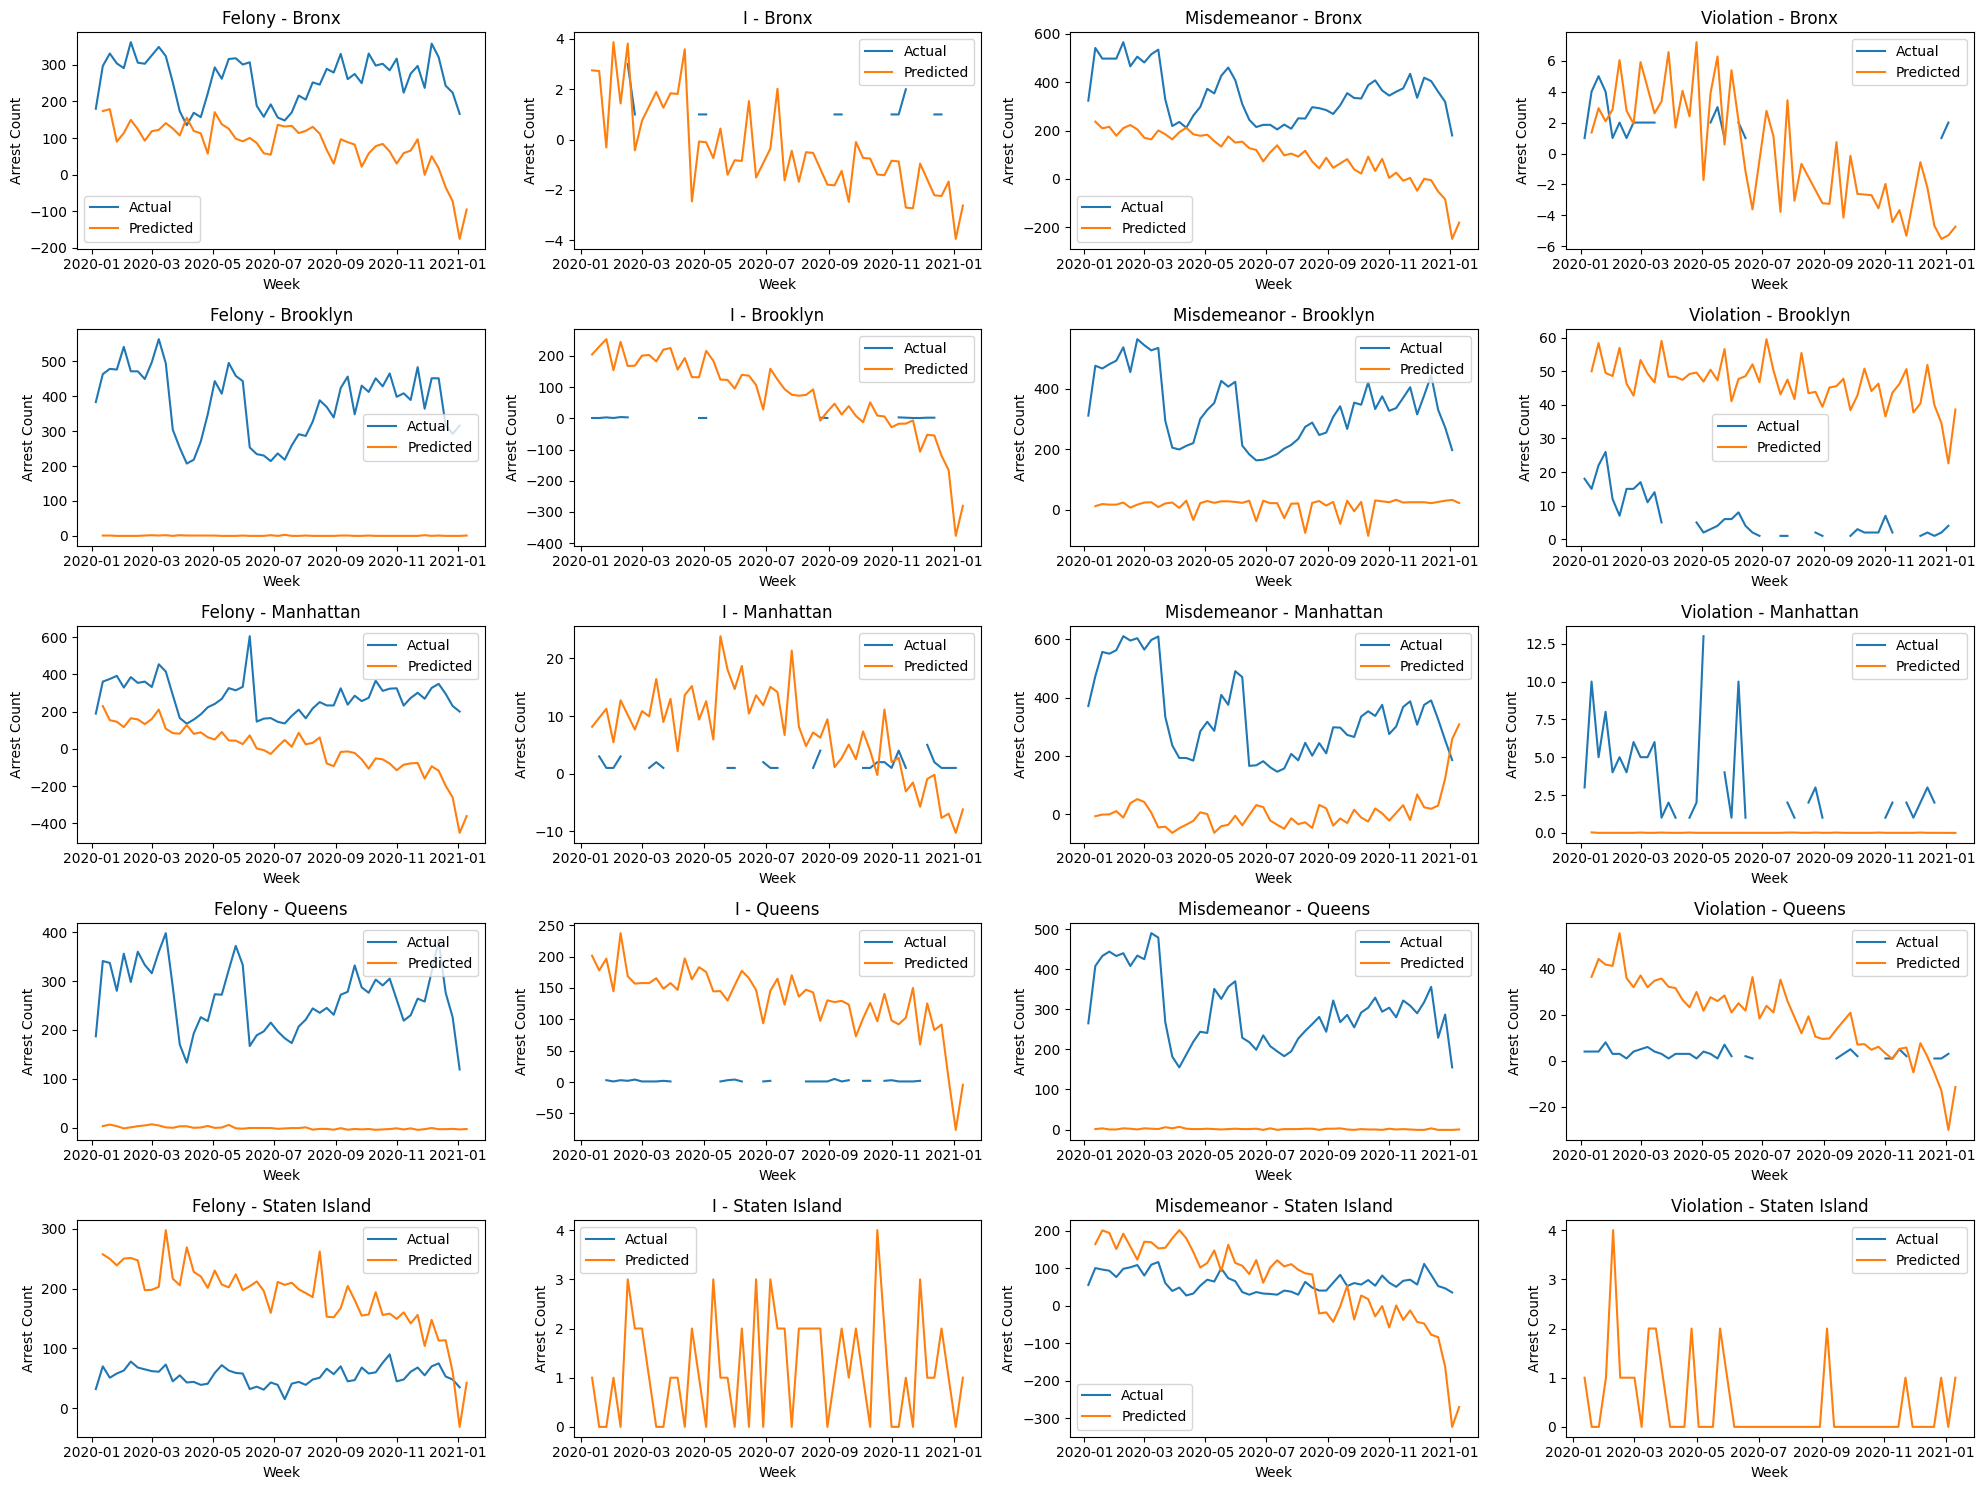

In [35]:
start_date = pd.to_datetime('2019-01-06')
end_date = pd.to_datetime('2020-01-05')

# Convert start_date and end_date to Timestamp objects
train_arrest_pivot.tail()

all_preds = []

# Convert start_date and end_date to index positions
start_pos = train_arrest_pivot.index.get_loc(start_date)
end_pos = train_arrest_pivot.index.get_loc(end_date)

# Iterate over each borough and law category in train_arrest_pivot
for borough in train_arrest_pivot.columns.get_level_values('ARREST_BORO').unique():
    for law_cat_cd in train_arrest_pivot.columns.get_level_values('LAW_CAT_CD').unique():
        # Prepare the data for the specific borough and law category
        data = train_arrest_pivot.xs((law_cat_cd, borough), level=('LAW_CAT_CD', 'ARREST_BORO'), axis=1)
        
        # Fit the SARIMA model with the best order and seasonal order to the data
        model = sm.tsa.SARIMAX(data, order=best_order, seasonal_order=best_seasonal_order)
        model_fit = model.fit()
        
        # Make predictions using index positions
        predictions = model_fit.predict(start="2020-01-06", end="2021-01-05")
        
        all_preds.append(predictions)
        
        # Print or do further processing with the predictions
        print(f'Predictions for {law_cat_cd} - {borough}:')
        print(predictions)
        
# Combine the predictions for all boroughs and law categories
all_predictions = pd.concat(all_preds, axis=1)

# Set the column names to the appropriate boroughs and law categories
all_predictions.columns = pd.MultiIndex.from_product([train_arrest_pivot.columns.get_level_values('LAW_CAT_CD').unique(),
                                                     train_arrest_pivot.columns.get_level_values('ARREST_BORO').unique()],
                                                    names=['LAW_CAT_CD', 'ARREST_BORO'])




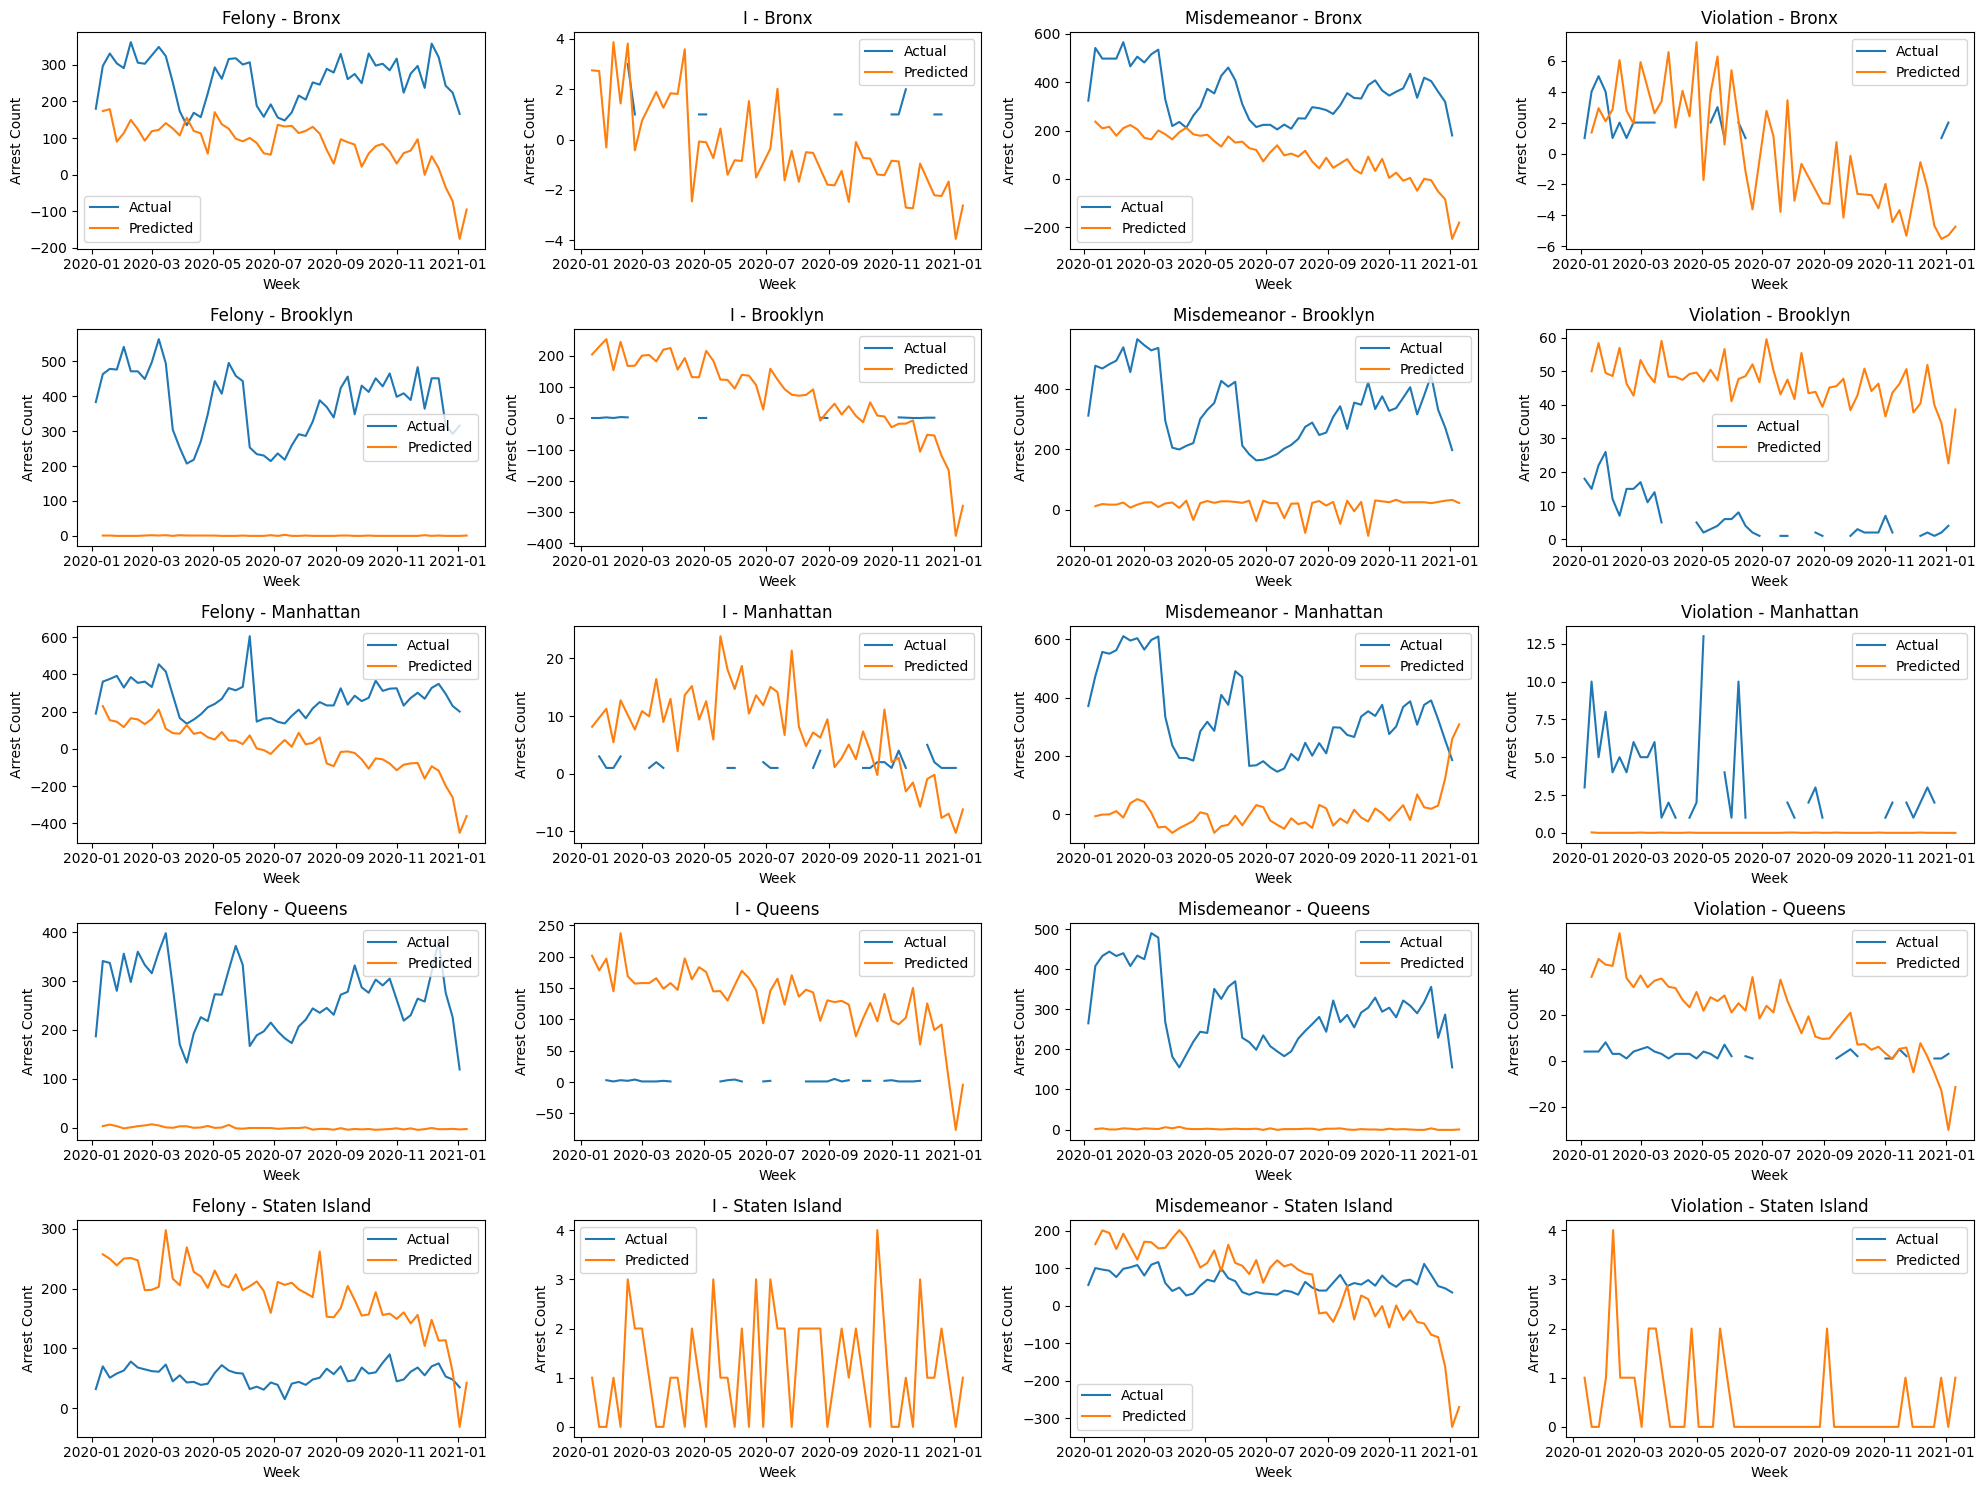

In [36]:
# Plot the predictions for each borough and law category
fig, axs = plt.subplots(len(train_arrest_pivot.columns.get_level_values('ARREST_BORO').unique()), len(train_arrest_pivot.columns.get_level_values('LAW_CAT_CD').unique()), figsize=(20, 15))

for i, borough in enumerate(train_arrest_pivot.columns.get_level_values('ARREST_BORO').unique()):
    for j, law_cat_cd in enumerate(train_arrest_pivot.columns.get_level_values('LAW_CAT_CD').unique()):
        try:
            borough_predictions = all_predictions[(law_cat_cd, borough)]
        except KeyError:
            # Handle missing predictions
            continue
        
        axs[i, j].plot(test_arrest_pivot.index, test_arrest_pivot[(law_cat_cd, borough)], label='Actual')
        axs[i, j].plot(borough_predictions.index, borough_predictions, label='Predicted')
        axs[i, j].set_xlabel('Week')
        axs[i, j].set_ylabel('Arrest Count')
        axs[i, j].set_title(f'{law_cat_cd} - {borough}')
        axs[i, j].legend()

plt.tight_layout()
plt.show()


### PROPHET

In [33]:
from prophet import Prophet

# Example for modeling arrests for Violation offenses in Queens
data = train_arrest_pivot.xs(("Violation", "Q"), level=('LAW_CAT_CD', 'ARREST_BORO'), axis=1)

# Prepare the data in a Prophet-compatible format
df = pd.DataFrame({'ds': data.index, 'y': data.values})

# Fit the Prophet model
model = Prophet()
model.fit(df)

# Make future predictions
future_dates = pd.date_range(start='2020-01-01', end='2020-12-01', freq='M')
future = pd.DataFrame({'ds': future_dates})
forecast = model.predict(future)


c:\Users\n3mes\miniconda3\envs\DS\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


KeyError: 'Q'

['ARREST_DATE']
DatetimeIndex(['2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31'],
              dtype='datetime64[ns]', name='ARREST_DATE', freq=None)
